In [45]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

import seaborn as sns



In [2]:
df = pd.read_csv('./wildfire-data.csv')

In [3]:
df.head()

,fire_year,fire_number,fire_name,current_size,size_class,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,industry_identifier_desc,...,distance_from_water_source,first_bucket_drop_date,bh_fs_date,bh_hectares,uc_fs_date,uc_hectares,to_fs_date,to_hectares,ex_fs_date,ex_hectares
0,2021,HWF053,NaN,5.50,C,59.522139,-119.926971,Provincial Land,Lightning,NaN,...,NaN,NaN,6/28/21 22:26,0.01,7/1/21 13:26,10.00,NaN,NaN,7/1/21 13:44,5.50
1,2021,RWF005,NaN,0.01,A,52.692262,-116.118960,Provincial Land,Forest Industry,NaN,...,NaN,NaN,3/30/21 14:30,0.01,3/30/21 14:30,0.01,3/30/21 14:35,0.01,4/9/21 8:30,0.01
2,2021,LWF014,NaN,0.10,A,55.937050,-110.719950,Indian Reservation,Incendiary,NaN,...,NaN,NaN,4/16/21 16:57,0.10,4/16/21 16:57,0.10,NaN,NaN,4/17/21 14:15,0.10
3,2021,MWF002,NaN,0.01,A,56.425933,-111.160750,Indian Reservation,Resident,NaN,...,NaN,NaN,4/17/21 15:20,0.01,4/17/21 15:20,0.01,NaN,NaN,4/17/21 15:24,0.01
4,2021,EWF014,NaN,7.13,C,53.693450,-116.058633,Private Land,Resident,NaN,...,NaN,NaN,4/1/21 19:10,7.13,4/2/21 11:00,7.13,4/2/21 15:52,7.13,4/12/21 14:30,7.13


In [4]:
categorical_columns = ['fire_origin', 'general_cause_desc',
       'industry_identifier_desc', 'responsible_group_desc', 'activity_class',
       'true_cause', 'det_agent', 'det_agent_type', 'dispatched_resource', 'assessment_resource',
      'fire_type', 'fire_position_on_slope',
       'weather_conditions_over_fire', 'wind_direction', 'fuel_type',
       'initial_action_by', 'ia_access', 'bucketing_on_fire', 'fire_forest_area','fire_start_part_of_day']

# Building a Data Processing Pipeline

## Processing Numerical Values
This section will involve imputing missing values for numerical features a well as normalizing values to give equal weight to all our features.

In [5]:
class NumImputer(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    result = X.copy()
    numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.drop(
        ['distance_from_water_source', 'fire_year', 'fire_location_latitude', 'fire_location_longitude']
      )
    print(numerical_columns)
    for col in numerical_columns:
      imputer = SimpleImputer(strategy='median')
      result[col] = imputer.fit_transform(X[[col]])

    return result

class NumStandardizer(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
    numerical_columns = numerical_columns.drop(
        ['distance_from_water_source', 'fire_year', 'fire_location_latitude', 'fire_location_longitude']
      )
    for col in numerical_columns:
      mean = df[col].mean()
      std = df[col].std()
      normalize_fn = lambda x: (x-mean)/std
      X[col] = X[col].apply(normalize_fn)
    return X

numerical_transformer = Pipeline(steps=[
    ('imputer', NumImputer()),
    ('scaler', NumStandardizer())
])

## fire_origin Processing
Due to the fact that we're missing values in fire_origin, we can use K-Nearest Neighbours in order to find the closest coordinates and impute the missing fire_origin values.

In [6]:

class MissingValueImputer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        missing_indices = X[X['fire_origin'].isna()].index
        # Fit NearestNeighbors model with non-missing data
        non_missing_indices = df[~df['fire_origin'].isna()].index
        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(df.loc[non_missing_indices, ['fire_location_latitude', 'fire_location_longitude']])

        if len(missing_indices) > 0 and len(non_missing_indices) > 0:
            distances, indices = nn.kneighbors(X.loc[missing_indices, ['fire_location_latitude', 'fire_location_longitude']])
            X.loc[missing_indices, 'fire_origin'] = df.iloc[non_missing_indices].iloc[indices.flatten()]['fire_origin'].values

        return X

# Define the pipeline
origin_transformer = Pipeline([
    ('missing_value_imputer', MissingValueImputer()),
])


## forest_area
This section will simply involve converting the fire_number feature into their respective forest_area. This will give more information about the location of the fire.

In [7]:
class ForestAreaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.forest_area = {
            'C': 'Calgary',
            'E': 'Edson',
            'H': 'High Level',
            'G': 'Grande Prairie',
            'L': 'Lac La Biche',
            'M': 'Fort McMurray',
            'P': 'Peace River',
            'R': 'Rocky',
            'S': 'Slave Lake',
            'W': 'Whitecourt'
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['fire_forest_area'] = X['fire_number'].apply(lambda x: self.forest_area.get(x[0]))
        return X.drop(['fire_number'], axis=1)

# Define your pipeline
forest_area_transformer = Pipeline([
    ('forest_area_transformer', ForestAreaTransformer())
])

## Processing Categorical Values
This section will involve imputing missing values as well as One-Hot encoding categorical values.

In [8]:
class CatImputer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    result = X.copy()
    for col in categorical_columns:
      result[col] = X[col].fillna('none')
    return result

class CatEncoder(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    for col in categorical_columns:
      one_hot_encoded_df = pd.get_dummies(X[col], prefix=f'{col}')
      X = pd.concat([X, one_hot_encoded_df], axis=1)
      X = X.drop([col], axis=1)
    return X

categorical_transformer = Pipeline(steps=[
    ('imputer', CatImputer()),
    ('onehot', CatEncoder())
])

## size_class
The size_class will be the feature we are trying to predict in this model. We will us Ordinal encoding for categories.

In [9]:
class SizeClassEncoder(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    enc = OrdinalEncoder(categories=[['A', 'B', 'C', 'D', 'E']])
    X['size_class'] = enc.fit_transform(df[['size_class']]).astype(int)
    return X


size_class_transformer = Pipeline(steps=[
    ('ordinal_encoder', SizeClassEncoder())
])

## Time
This section will convert date and time into relative time differences which are much more useful features to use in a model.

In [60]:
class TimeFormat(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['fire_start_date'] = X['fire_start_date'].fillna(method='bfill')
        X['fire_start_date'] = X['fire_start_date'].fillna(method='ffill')

        date_features = ['fire_start_date', 'discovered_date', 'reported_date', 'dispatch_date','start_for_fire_date', 'assessment_datetime', 'ia_arrival_at_fire_date', 'fire_fighting_start_date', 'first_bucket_drop_date', 'ex_fs_date']

        for feature in date_features:
            date_format = "%m/%d/%y %H:%M"
            X[feature] = pd.to_datetime(X[feature], format=date_format, errors='coerce')

        def generate_time_features(X):

            def timedelta_to_minutes(td):
                return td.total_seconds() / 60 if pd.notna(td) else np.nan


            def compute_time_difference(start, end):
                if pd.isna(start) or pd.isna(end):
                    return np.nan
                return timedelta_to_minutes(end - start)
            X['time_to_discovery'] = X.apply(lambda row: compute_time_difference(row['fire_start_date'], row['discovered_date']), axis=1)
            X['time_to_report'] = X.apply(lambda row: compute_time_difference(row['fire_start_date'], row['reported_date']), axis=1)
            X['time_to_dispatch'] = X.apply(lambda row: compute_time_difference(row['fire_start_date'], row['dispatch_date']), axis=1)
            X['time_to_start_for_fire'] = X.apply(lambda row: compute_time_difference(row['fire_start_date'], row['start_for_fire_date']), axis=1)
            X['time_to_assessment'] = X.apply(lambda row: compute_time_difference(row['fire_start_date'], row['assessment_datetime']), axis=1)
            X['time_to_ia_arrival'] = X.apply(lambda row: compute_time_difference(row['fire_start_date'], row['ia_arrival_at_fire_date']), axis=1)
            X['time_to_start_fighting'] = X.apply(lambda row: compute_time_difference(row['fire_start_date'], row['fire_fighting_start_date']), axis=1)
            return X.drop(['ex_fs_date', 'bh_fs_date', 'uc_fs_date', 'to_fs_date', 'discovered_date',
                           'reported_date', 'dispatch_date', 'start_for_fire_date', 'assessment_datetime', 'ia_arrival_at_fire_date',
                           'fire_fighting_start_date', 'first_bucket_drop_date'], axis=1)

        X = generate_time_features(X)

        # List of columns for which missing values should be imputed with the median
        columns_to_impute = ['time_to_discovery', 'time_to_report', 'time_to_dispatch',
                            'time_to_start_for_fire', 'time_to_assessment', 'time_to_ia_arrival',
                            'time_to_start_fighting']

        # Impute missing values with the median for specified columns
        X[columns_to_impute] = X[columns_to_impute].fillna(X[columns_to_impute].median())
        return X

class TimeNormalizer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    columns = ['time_to_discovery', 'time_to_report', 'time_to_dispatch',
                            'time_to_start_for_fire', 'time_to_assessment', 'time_to_ia_arrival',
                            'time_to_start_fighting']
    for col in columns:
      mean = X[col].mean()
      std = X[col].std()
      normalize_fn = lambda x: (x-mean)/std
      X[col] = X[col].apply(normalize_fn)
    return X

time_transformer = Pipeline(steps=[
    ('time_format', TimeFormat()),
    ('normalize', TimeNormalizer())
])


## Date
This section will simply convert dates into the time in the month, week, and day.

In [11]:
class DateEncoder(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    date_format = "%m/%d/%y %H:%M"
    X['fire_start_date'] = X['fire_start_date'].fillna(method='bfill')
    X['fire_start_date'] = X['fire_start_date'].fillna(method='ffill')
    X['fire_start_date'] = pd.to_datetime(X['fire_start_date'], format=date_format)
    X['fire_start_month'] = X['fire_start_date'].dt.month
    X['fire_start_weekday'] = X['fire_start_date'].dt.weekday
    def part_of_day(hour):
      if 5 <= hour < 12:
          return 'Morning'
      elif 12 <= hour < 17:
          return 'Afternoon'
      elif 17 <= hour < 21:
          return 'Evening'
      else:
          return 'Night'
    X['fire_start_part_of_day'] = X['fire_start_date'].dt.hour.apply(part_of_day)
    return X.drop(['fire_start_date'], axis=1)

date_transformer = Pipeline(steps=[
    ('date', DateEncoder())
])


In [12]:
class SourceImputer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    X['distance_from_water_source'] = X['distance_from_water_source'].fillna(1e9)
    return X

class Sigmoid(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    def sigmoid(x):
      return 1 / (1 + np.exp(-x))
    X['distance_from_water_source'] = X['distance_from_water_source'].apply(sigmoid)
    return X

water_source_transformer = Pipeline(steps=[
    ('source_impute', SourceImputer()),
    ('sigmoid', Sigmoid())
])

In [13]:
df = df.drop(['discovered_size', 'bh_hectares', 'uc_hectares', 'ex_hectares', 'fire_name'], axis=1)

In [14]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.drop(
    ['distance_from_water_source', 'fire_year', 'fire_location_latitude', 'fire_location_longitude']
  )

preprocessor = Pipeline(steps=[
    ('origin', origin_transformer),
    ('num', numerical_transformer),
    ('forest_area', forest_area_transformer),
    ('size_class', size_class_transformer),
    ('time', time_transformer),
    ('date', date_transformer),
    ('water_source', water_source_transformer),
    ('cat', categorical_transformer)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X = pipeline.fit_transform(df)
X = X.drop(['current_size'], axis=1)
y = X.pop('size_class')

Index(['current_size', 'assessment_hectares', 'fire_spread_rate',
       'temperature', 'relative_humidity', 'wind_speed',
       'fire_fighting_start_size', 'to_hectares'],
      dtype='object')


In [15]:
pd.set_option('display.max_columns', None)

# Now df.head() will display all columns
print(X.head())

   fire_year  fire_location_latitude  fire_location_longitude  \
0       2021               59.522139              -119.926971   
1       2021               52.692262              -116.118960   
2       2021               55.937050              -110.719950   
3       2021               56.425933              -111.160750   
4       2021               53.693450              -116.058633   

   assessment_hectares  fire_spread_rate  temperature  relative_humidity  \
0            -0.035660          0.827659     1.451208          -0.449592   
1            -0.035660         -0.337889    -2.103627           0.244187   
2            -0.034163         -0.143631    -0.246624          -1.410209   
3            -0.035660         -0.337889    -1.440412           0.511025   
4             0.047317          1.604691    -0.671082          -1.410209   

   wind_speed  fire_fighting_start_size  distance_from_water_source  \
0    0.264532                  0.001719                         1.0   
1    0.146

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [24]:
models = {
  'KNN': KNeighborsClassifier(),
  'BalancedDecisionTree': DecisionTreeClassifier(random_state=42),
  'RandomForest': RandomForestClassifier(random_state=42),
  'XGBoost': XGBClassifier(random_state=42),
}

param_grids = {
  'KNN': {
    'n_neighbors': np.arange(1, 3),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
  },
  'BalancedDecisionTree': {
    'max_features': ['auto'],
    'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    'class_weight': ['balanced', None]
  },
  'RandomForest': {
      'n_estimators': [100, 200, 500],
      'max_depth': [None, 10, 30],
      'min_samples_split': [2, 5, 10],
  },
  'XGBoost': {
      'n_estimators': [100, 200, 500],
      'learning_rate': [0.01, 0.1, 0.3],
      'max_depth': [3, 6, 10],
  },
}

# 3-fold cross-validation
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Train and tune the models
grids = {}
for model_name, model in models.items():
    #print(f'Training and tuning {model_name}...')
    grids[model_name] = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
    grids[model_name].fit(X_train, y_train)
    best_params = grids[model_name].best_params_
    best_score = np.sqrt(-1 * grids[model_name].best_score_)

    print(f'Best parameters for {model_name}: {best_params}')
    print(f'Best RMSE for {model_name}: {best_score}\n')



Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for KNN: {'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
Best RMSE for KNN: 0.7418254225735456

Fitting 3 folds for each of 60 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


Best parameters for BalancedDecisionTree: {'ccp_alpha': 0.001, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 'auto'}
Best RMSE for BalancedDecisionTree: 0.6464697895073549

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters for RandomForest: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE for RandomForest: 0.44714844648703994

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Best RMSE for XGBoost: 0.3730831781630389



# Testing Models


In [25]:
model_stats = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

In [61]:
def evaluate_model(model_name, y_pred):
  print(model_name+':')

  cm = confusion_matrix(y_test, y_pred)

  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred, output_dict=True)
  macro_precision = report['macro avg']['precision']
  macro_recall = report['macro avg']['recall']
  macro_f1 = report['macro avg']['f1-score']

  # Append Metrics to DataFrame
  global model_stats
  model_stats.loc[len(model_stats)] = [model_name, accuracy, macro_precision, macro_recall, macro_f1]

  plt.figure(figsize=(10,7))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('Truth')
  plt.title(f'{model_name} Confusion Matrix')
  plt.show()

  print(classification_report(y_test, y_pred))

## Random Forest

In [63]:
rf_model = RandomForestClassifier(max_depth=30, min_samples_split=2, n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, n_estimators=200)

In [64]:
y_pred = rf_model.predict(X_test)

RandomForest:


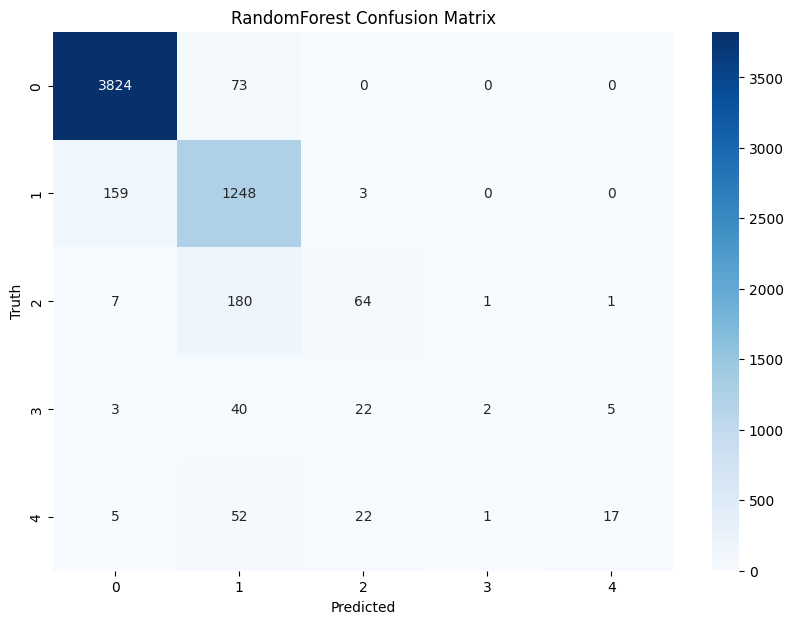

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3897
           1       0.78      0.89      0.83      1410
           2       0.58      0.25      0.35       253
           3       0.50      0.03      0.05        72
           4       0.74      0.18      0.28        97

    accuracy                           0.90      5729
   macro avg       0.71      0.46      0.50      5729
weighted avg       0.89      0.90      0.88      5729



In [65]:
evaluate_model('RandomForest', y_pred)

## XGBoost

In [67]:
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=200)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [68]:
y_pred = xgb_model.predict(X_test)

XGBoost:


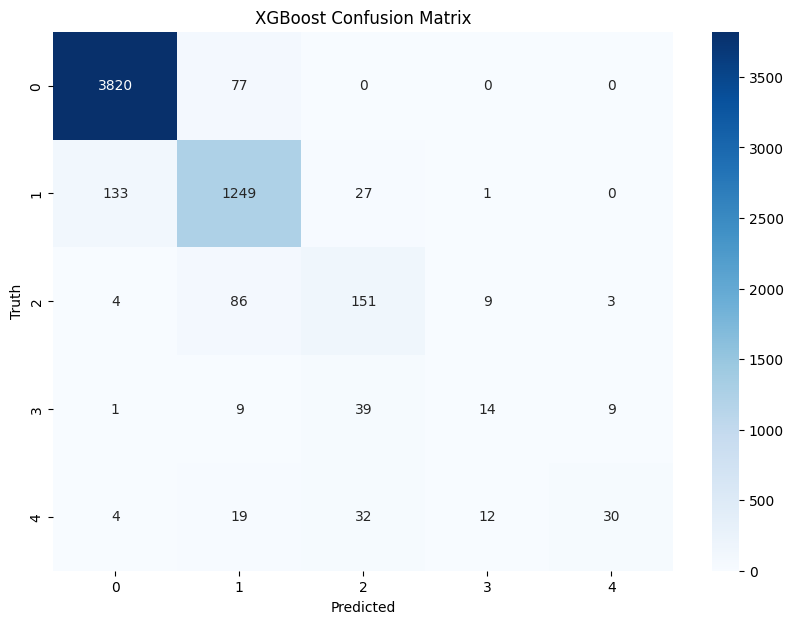

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3897
           1       0.87      0.89      0.88      1410
           2       0.61      0.60      0.60       253
           3       0.39      0.19      0.26        72
           4       0.71      0.31      0.43        97

    accuracy                           0.92      5729
   macro avg       0.71      0.59      0.63      5729
weighted avg       0.91      0.92      0.91      5729



In [69]:
evaluate_model('XGBoost', y_pred)

## Balanced Decision Tree with Bagging

In [70]:
base_estimator = DecisionTreeClassifier(class_weight='balanced',
                       criterion='entropy', max_depth=5,
                       random_state=42)
bbc = BalancedBaggingClassifier(base_estimator=base_estimator, sampling_strategy='auto',
                                replacement=False, random_state=42)

In [71]:
bbc.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                criterion='entropy',
                                                                max_depth=5,
                                                                random_state=42),
                          random_state=42)

In [72]:
y_pred = bbc.predict(X_test)

Balanced Decision Tree with Bagging:


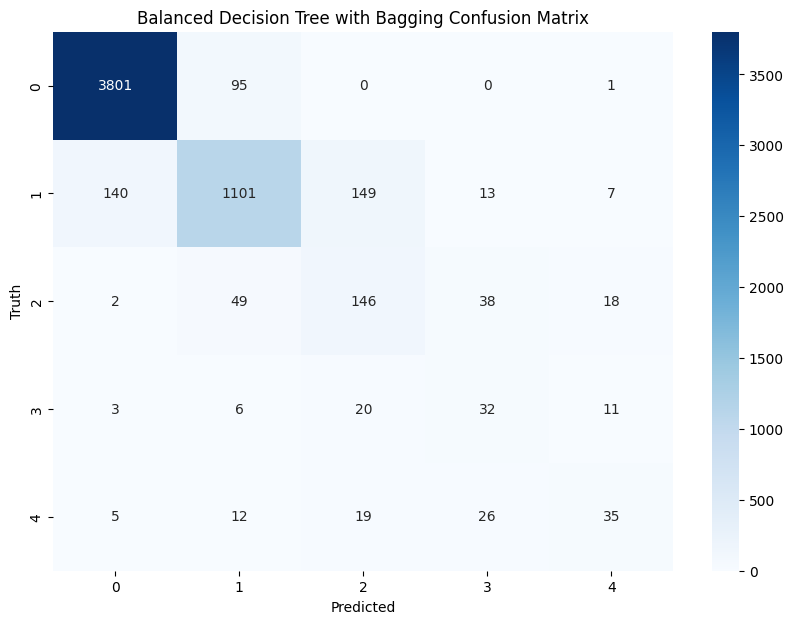

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3897
           1       0.87      0.78      0.82      1410
           2       0.44      0.58      0.50       253
           3       0.29      0.44      0.35        72
           4       0.49      0.36      0.41        97

    accuracy                           0.89      5729
   macro avg       0.61      0.63      0.61      5729
weighted avg       0.90      0.89      0.90      5729



In [73]:
evaluate_model('Balanced Decision Tree with Bagging', y_pred)

## Balanced Decision Tree

In [74]:
bdt_model = DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=9, class_weight='balanced', random_state=42)
bdt_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.001, class_weight='balanced',
                       criterion='entropy', max_depth=9, random_state=42)

In [75]:
y_pred = bdt_model.predict(X_test)

Balanced Decision Tree:


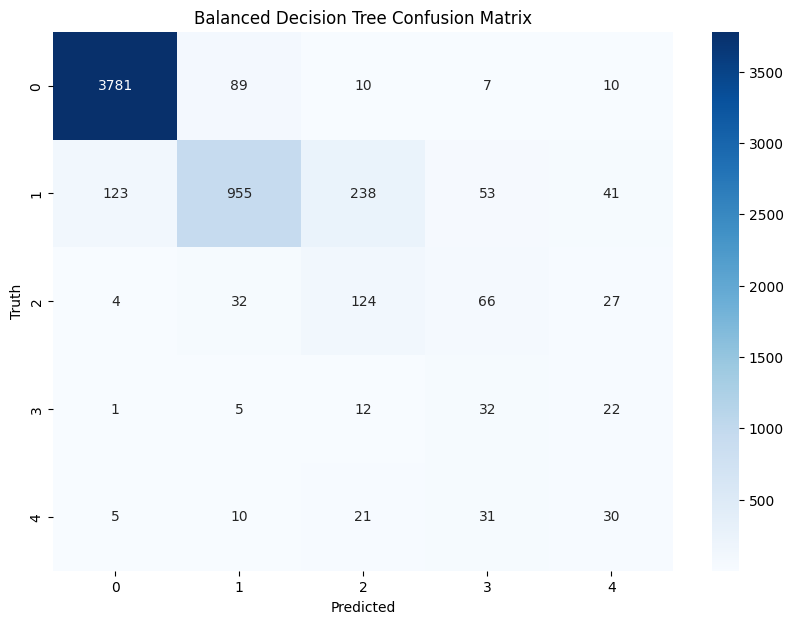

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3897
           1       0.88      0.68      0.76      1410
           2       0.31      0.49      0.38       253
           3       0.17      0.44      0.25        72
           4       0.23      0.31      0.26        97

    accuracy                           0.86      5729
   macro avg       0.51      0.58      0.52      5729
weighted avg       0.89      0.86      0.87      5729



In [76]:
evaluate_model('Balanced Decision Tree', y_pred)

## Support Vector Machine

In [78]:
svc_model = SVC(kernel='linear', probability=True, random_state=42)
svc_model.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [79]:
y_pred = svc_model.predict(X_test)

Support Vector Machine:


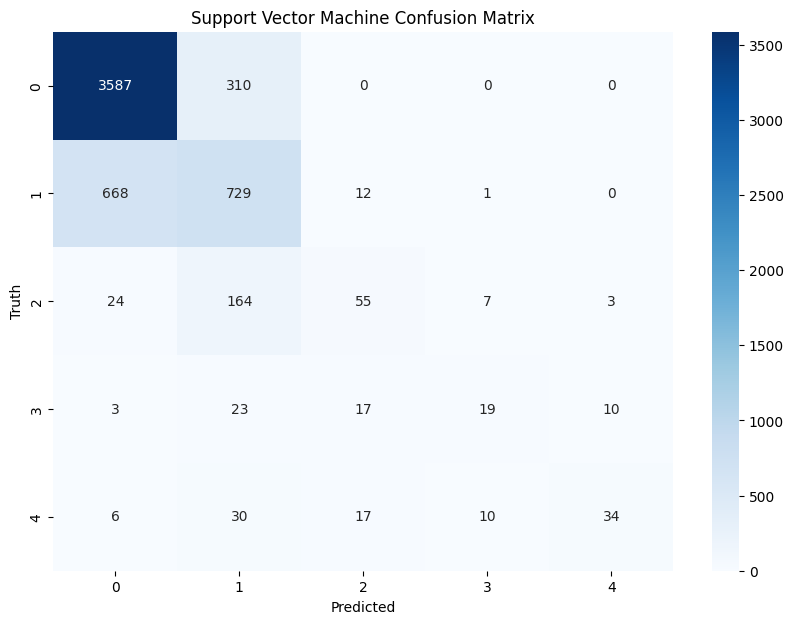

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      3897
           1       0.58      0.52      0.55      1410
           2       0.54      0.22      0.31       253
           3       0.51      0.26      0.35        72
           4       0.72      0.35      0.47        97

    accuracy                           0.77      5729
   macro avg       0.64      0.45      0.51      5729
weighted avg       0.75      0.77      0.76      5729



In [80]:
evaluate_model('Support Vector Machine', y_pred)

## K-Nearest Neighbors

In [50]:
knn_model = KNeighborsClassifier(n_neighbors=2, p=1, weights='uniform')
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2, p=1)

In [51]:
y_pred = knn_model.predict(X_test)

KNN:


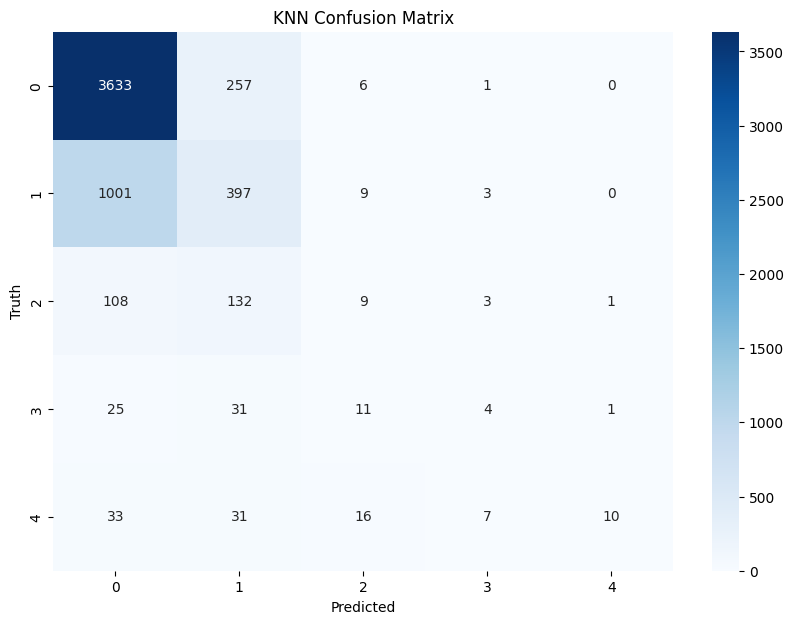

              precision    recall  f1-score   support

           0       0.76      0.93      0.84      3897
           1       0.47      0.28      0.35      1410
           2       0.18      0.04      0.06       253
           3       0.22      0.06      0.09        72
           4       0.83      0.10      0.18        97

    accuracy                           0.71      5729
   macro avg       0.49      0.28      0.30      5729
weighted avg       0.65      0.71      0.66      5729



In [62]:
evaluate_model('KNN', y_pred)

# Comparing the models

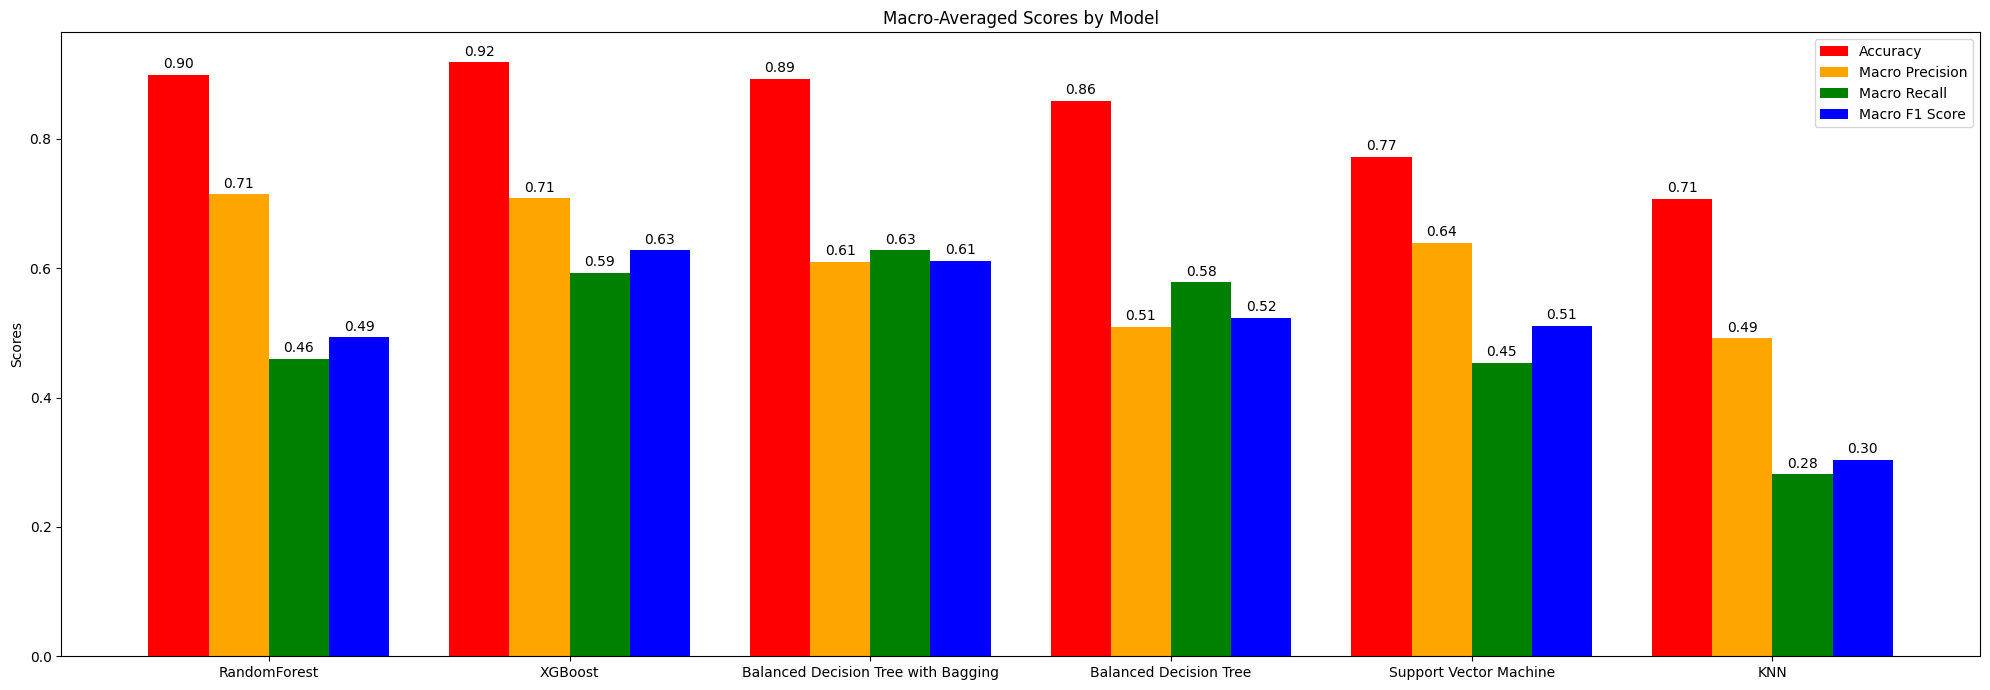

In [59]:
# Set the size of the plot
plt.figure(figsize=(20, 7))

# Number of models
n_models = len(model_stats)

# X locations for the groups
ind = np.arange(n_models)

# Width of the bars
width = 0.2

# Plotting
plt.bar(ind, model_stats['Accuracy'], width, label='Accuracy', color='red')
plt.bar(ind + width, model_stats['Precision'], width, label='Macro Precision', color="orange")
plt.bar(ind + 2*width, model_stats['Recall'], width, label='Macro Recall', color="green")
plt.bar(ind + 3*width, model_stats['F1 Score'], width, label='Macro F1 Score', color="blue")

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Scores')
plt.title('Macro-Averaged Scores by Model')
plt.xticks(ind + width * 1.5, model_stats['Model'])
plt.legend(loc='best')

# Adding the values on top of the bars
for i in ind:
    plt.text(x=i, y=model_stats['Accuracy'][i] + 0.01, s=f"{model_stats['Accuracy'][i]:.2f}", ha='center')
    plt.text(x=i + width, y=model_stats['Precision'][i] + 0.01, s=f"{model_stats['Precision'][i]:.2f}", ha='center')
    plt.text(x=i + 2*width, y=model_stats['Recall'][i] + 0.01, s=f"{model_stats['Recall'][i]:.2f}", ha='center')
    plt.text(x=i + 3*width, y=model_stats['F1 Score'][i] + 0.01, s=f"{model_stats['F1 Score'][i]:.2f}", ha='center')

plt.tight_layout()
plt.show()

# Evaluation

As can be seen, XGBoost results in the best accuracy. However, because of the imbalanced dataset, where there were more data points for size classes A and B and less data points for size classes D and E, the models suffered. The Balanced Decision Tree with Bagging ended up having the best accuracy with classes with less data points. This resulted in them having the best Recall score.

Although XGBoost has the best accuracy, it may be more effective to use Balanced Decision Tree with Bagging as it provided more consistent results for all size classes which should be the priority.